# Evaluation of the final CNN model

## Evaluation 1:
First the model is trained on subjects A, B, D, E, F.
The model is then evaluated on the test subject C. Up until this point the model has not been exposed to this data.

## Evaluation 2:
Expose the model to a set of data from all subjects during the training/validation process then use a different set, also containing data from all the subjects for testing. The data was split 60% training, 20% validation and 20% testing. Five-fold cross-validation was used.

## Evaluation 3:
Six-fold subject-wise cross-validation (one fold for each subject).

## Notebook setup

In [1]:
# Plot graphs inline
%matplotlib inline

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data.

In [2]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/doppler_spectrograms_without_corrupt/3/'

RESULTS_PATH = BASE_PATH + 'results/CNN_final_model_evaluation_without_corrupt/'
HYPERPARAMETER_PATH = BASE_PATH + 'results/CNN_hyperparameter_search/'

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

Import remaining packages

In [3]:
import numpy as np
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [4]:
# uncomment to install scikit-optimize
# !pip install git+https://GitHub.com/scikit-optimize/scikit-optimize/
from skopt import load

In [5]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup

In [6]:
RUN_EVALUATIONS = False

SAVE_RESULTS_TEST_C = False
SAVE_GRAPHS_TEST_C = False

SAVE_RESULTS_20 = False
SAVE_GRAPHS_20 = False

SAVE_RESULTS_6_FOLD = False
SAVE_GRAPHS_6_FOLD = False

In [7]:
# Patience chosen from notebook 9
nb_epoch = 100
# nb_epoch = 1 #testing
patience = 7

In [8]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)

# input image dimensions
img_rows, img_cols = 75, 75

users = ["A", "B", "C", "D", "E", "F"] 

In [9]:
def load_data(user_letter):
    """
    load the data and labels associated with a particular user/subject (interchangeable)
    :param user_letter: Letter representing subject/user (A-F)
    :type user_letter: str
    :return: data and labels
    :rtype: tuple of the form (data, labels)
    """
    with open(DATA_PATH + user_letter + "_data.pkl", 'rb') as data_file:
        data = pickle.load(data_file)
        data = data.reshape(data.shape[0], 1, 75, 75)
        
    with open(DATA_PATH + user_letter + "_labels.pkl", 'rb') as labels_file:
        labels = pickle.load(labels_file)
        labels = np.reshape(labels, (len(labels), 1))

    return data, labels

In [10]:
datasets = {}
for user in users:
    data, labels = load_data(user)
    datasets[user] = {"data": data, "labels": labels}

## Define Model

In [11]:
def make_model(nb_filters, img_rows, img_cols, nb_classes, activation,
               dropout, num_dense_nodes, num_dense_layers,
               kernel_size, pooling_size):
    """
    Make and return the CNN model
    :param nb_filters: Number of filters to use in layers 1,2 and 3,4 respectively
    :type nb_filters: str containing the number of filters for the first two layers followed by 
    the last two layers, for example: "16-32"
    :param img_rows: image height
    :type img_rows: int
    :param img_cols: image width
    :type img_cols: int
    :param nb_classes: Number of classes to be predicted
    :type nb_classes: int
    :param activation: Activation function to use after each conv and dense layer
    :type activation: Keras activation function
    :param dropout: dropout rate for dropout layers
    :type dropout: float
    :param num_dense_nodes: number of dense nodes in dense layer
    :type num_dense_nodes: int
    :param num_dense_layers: number of dense layers
    :type num_dense_layers: int
    :param kernel_size: kernel size to use
    :type kernel_size: int but will be converted to tuple (int, int) 
                        internally as kernel is a square
    :param pooling_size: pool size
    :type pooling_size: int but will be converted to tuple (int, int)
                        internally as requires vertical and horizontal
    :return: CNN model
    :rtype: Keras sequential model
    """
    kernel_size = (kernel_size, kernel_size)
    pooling_size = (pooling_size, pooling_size)
    
    model = Sequential(name=nb_filters)
    nb_filters = nb_filters.split("-")
    size_1 = int(nb_filters[0])
    size_2 = int(nb_filters[1])

    model.add(Convolution2D(size_1, kernel_size, padding='same', input_shape=(1, img_rows, img_cols), activation=activation))
    model.add(Convolution2D(size_1, kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout))

    model.add(Convolution2D(size_2, kernel_size, padding='same', activation=activation))
    model.add(Convolution2D(size_2, kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout))

    model.add(Flatten())
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

## Train Model Function

In [12]:
def train_model(train_data, train_labels, test_data, test_labels, hyperparameters, epochs, patience):
    """
    Make and train the CNN model
    :param train_data: Data to train the model on
    :type train_data: array of images represented as numpy arrays
    :param train_labels: Labels corresponding to the training data
    :type train_labels: array of integers representing the labels in the same order as train_data
    :param test_data: Data to validate the model on
    :type test_data: array of images represented as numpy arrays
    :param test_labels: Labels corresponding to the validation data
    :type test_labels: array of integers representing the labels in the same order as validation_data
    :param hyperparameters: Selected hyperparameters 
    :type hyperparameters: dictionary
    :param epochs: number of epochs to train for
    :type epochs: int
    :param patience: patience value for early stopping (-1 for no early stopping)
    :type patience: int
    :return: training history and trained model
    :rtype: tuple of the form (history, model)
    """
    parameters = hyperparameters
    model = make_model("8-16", img_rows, img_cols, nb_classes, parameters[2],
               parameters[3], parameters[4], parameters[5],
               parameters[6], parameters[7])
    
    optimizer = parameters[0] 
    learning_rate = parameters[1]
    if optimizer == 'adam':
        selected_optimizer = Adam(lr=learning_rate)

    elif optimizer == 'sgd_standard':
        selected_optimizer = SGD(lr=learning_rate)

    else:
        # nestrov momentum
        selected_optimizer = SGD(lr=learning_rate, decay=1e-6, momentum=0.9,
                                 nesterov=True)

    model.compile(loss='categorical_crossentropy',
                  optimizer=selected_optimizer,
                  metrics=['accuracy'])
    
    callback_list = []
    if patience != -1:
        early_stopping = EarlyStopping(monitor='val_acc', patience=patience)
        callback_list.append(early_stopping)
        
    history = model.fit(train_data, train_labels,
                        batch_size=parameters[8],
                        epochs=epochs,
                        shuffle=True, 
                        validation_data=(test_data, test_labels),
                        callbacks=callback_list,
                        verbose=0)
    
    return history, model

## Evaluate Model function

In [13]:
def evaluate_model(model, test_data, test_labels, batch_size, target_names):
    """
    Evaluate the trained model
    :param model: trained keras model
    :type model: keras model
    :param test_data: data to evaluate the model with
    :type test_data: array of images represented as numpy arrays
    :param test_labels: labels for the test data
    :type test_labels: array of integers representing the labels in the same order as test_data
    :param batch_size: batch size to use during the evaluation
    :type batch_size: int
    :param target_names: Names of the classes for confusion matrix
    :type target_names: string array
    :return: loss, accuracy, classification report and confusion matrix
    :rtype: dictionary with the keys "loss", "accuracy", "classification_report" and "confusion_matrix"
    """
    evaluation = model.evaluate(test_data, test_labels,
                                batch_size=batch_size, verbose=1)

    loss = evaluation[0]
    accuracy = evaluation[1]

    test_pred = model.predict_classes(test_data)
    report = classification_report(np.argmax(test_labels,axis=1),
                                   test_pred, target_names=target_names)
    conf_matrix = confusion_matrix(np.argmax(test_labels,axis=1), test_pred)
    return {
        "loss": loss,
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": conf_matrix
    }

### Load hyperparameter results

In [14]:
# needed for loading results (objective needs to be defined)
def objective():
    """
    Dummy objective function to be able to load hyperparameter search results.
    (objective needs to be defined)
    """
    return 0

In [15]:
dimensions = ['optimizer', 'learning_rate', 'activation', 'dropout',
              'num_dense_nodes', 'num_dense_layers', 'kernel_size',
              'pooling_size', 'batch_size']

res_gp = load(HYPERPARAMETER_PATH + "res_gp_complete.pkl")
parameters = res_gp.x

In [16]:
for index, parameter in enumerate(parameters):
    print(dimensions[index] + ":", parameter)

optimizer: adam
learning_rate: 0.0012375685948764468
activation: relu
dropout: 0.597428888669298
num_dense_nodes: 1024
num_dense_layers: 3
kernel_size: 3
pooling_size: 2
batch_size: 576


# Evaluating on subject C

In [17]:
def split_train_validation_test(test_user, total_folds=5, validation_fold=0):
    """
    split the data into:
        a test set composed of all data from test subject
        a train set composed of 80% (depending on total folds) of remaining subjects
        a validation set composed of the remaining 20%
    :param test_user: Subject to use for test set (A-F)
    :type test_user: str
    :param total_folds: Number of folds to split data into (decides percentage for validation set
                        2 folds = 50%, 3 folds = 33.3%, 4 folds = 25%, 5 folds = 20%
    :type total_folds: int
    :param validation_fold: Fold to use for validation set
    :type validation_fold: int
    :return: data and labels for the train, validation and test set
    :rtype: dictionary with keys "train_data", "train_labels", 
                                "validation_data", "validation_labels",
                                "test_data", "test_labels"
    """
    # split by user then action
    labels = np.arange(0, 7)
    actions = {}
    for user in users:
        actions[user] = {}
        for label in labels:
            actions[user][str(label)] = []
        
    for user in users:
        data = datasets[user]["data"]
        labels = datasets[user]["labels"]
        for index, label in enumerate(labels):
            actions[user][str(label[0])].append(data[index])
        
    # convert to numpy array
    labels = np.arange(0, 7)
    for user in users:
        for label in labels:
            actions[user][str(label)] = np.array(actions[user][str(label)])
            
    train_labels = []
    train_data = []
    validation_labels = []
    validation_data = []
    test_labels = []
    test_data = []
    # each user A->F
    for user in users:
        # 0 -> 6
        for label in labels:            
            if user == test_user:
                testing_data = actions[user][str(label)]
                testing_labels = np.full(testing_data.shape[0], label)
                test_data.append(testing_data)
                test_labels.append(testing_labels)  
                
            else:
                # for example, if using 5 folds splits data into 5 subsets
                split_actions = np.array_split(actions[user][str(label)], total_folds)
                training_data = []
                validating_data = []
                for fold in range(total_folds):
                    if fold == validation_fold:
                        validating_data.append(split_actions[fold])
                    else:
                        training_data.append(split_actions[fold])

                training_data = np.concatenate(training_data, axis=0)
                training_labels = np.full(training_data.shape[0], label)
                validating_data = np.concatenate(validating_data, axis=0)
                validating_labels = np.full(validating_data.shape[0], label)

                train_data.append(training_data)
                train_labels.append(training_labels)
                validation_data.append(validating_data)
                validation_labels.append(validating_labels)   
            
    train_labels = np.concatenate(train_labels, axis=0)
    train_data = np.concatenate(train_data, axis=0)
    validation_labels = np.concatenate(validation_labels, axis=0)
    validation_data = np.concatenate(validation_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    
    train_labels = np_utils.to_categorical(train_labels, nb_classes)
    validation_labels = np_utils.to_categorical(validation_labels, nb_classes)
    test_labels = np_utils.to_categorical(test_labels, nb_classes)
    
    train_data = train_data.astype('float32')/255
    validation_data = validation_data.astype('float32')/255
    test_data = test_data.astype('float32')/255
    
    return {
        "train_data": train_data,
        "train_labels": train_labels,
        "validation_data": validation_data,
        "validation_labels": validation_labels,
        "test_data": test_data,
        "test_labels": test_labels
       }

## Train Model

In [18]:
data_split = split_train_validation_test("C") # subject c is test subject

# 80% of each subject (excluding C)
train_data = data_split["train_data"]
train_labels = data_split["train_labels"]

# 20% taken from each subject (excluding C)
validation_data = data_split["validation_data"]
validation_labels = data_split["validation_labels"]

# subject C
test_data = data_split["test_data"]
test_labels = data_split["test_labels"]

In [19]:
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)

(28301, 1, 75, 75)
(7088, 1, 75, 75)
(7966, 1, 75, 75)


In [20]:
if RUN_EVALUATIONS:
    history, model = train_model(train_data, train_labels,
                                 validation_data, validation_labels,
                                 parameters, nb_epoch, patience)

## Evaluate Model

In [21]:
if RUN_EVALUATIONS:
    results = evaluate_model(model, test_data, test_labels, parameters[8], target_names)
    results["history"] = history.history

## Save Results

In [22]:
if SAVE_RESULTS_TEST_C:
    with open(RESULTS_PATH + "results_test_c.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

## Load Results

In [23]:
with open(RESULTS_PATH + "results_test_c.pkl", 'rb') as results_file:
    results = pickle.load(results_file)

## Visualize Results

In [24]:
print("Accuracy:", results["accuracy"]*100)

Accuracy: 69.93472267567978


### Accuracy

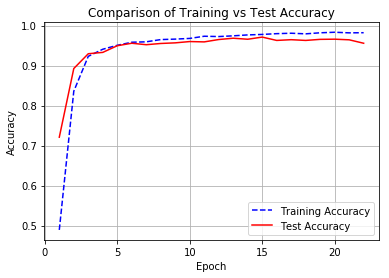

In [25]:
training_acc = results["history"]['acc']
test_acc = results["history"]['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_acc) + 1)

# Visualize loss history
plt.plot(epoch_count, training_acc, 'b--')
plt.plot(epoch_count, test_acc, 'r-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Comparison of Training vs Test Accuracy")
plt.grid()
if SAVE_GRAPHS_TEST_C:
    plt.savefig(RESULTS_PATH + "training_vs_test_acc.pdf", format='pdf')
plt.show()

### Loss

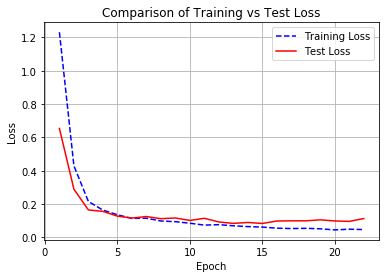

In [26]:
training_loss = results["history"]['loss']
test_loss = results["history"]['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'b--')
plt.plot(epoch_count, test_loss, 'r-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Comparison of Training vs Test Loss")
plt.grid()
if SAVE_GRAPHS_TEST_C:
    plt.savefig(RESULTS_PATH + "training_vs_test_loss.pdf", format='pdf')
plt.show()

### Confusion Matrix

In [27]:
def plot_confusion_matrix(cm, classes, title="Confusion Matrix", normalized=True, save=False, path='/'):
    """
    Plot the confusion matrix, code taken from:
     https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: confusion matrix to plot
    :param classes: class labels
    :param title: title of the plot
    :param normalized: use normalized version or not
    :param save: save the graph toggle
    :param path: path to save the graph to
    """
    if normalized:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save:
        plt.savefig(path, format='pdf')
    plt.show()

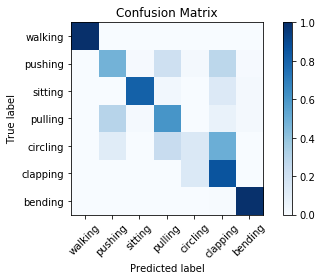

In [28]:
plot_confusion_matrix(results["confusion_matrix"], target_names,
                      save=SAVE_GRAPHS_TEST_C, path=RESULTS_PATH + "confusion_matrix.pdf")

In [29]:
K.clear_session()

# Evaluating on subset of the data (all subjects) 5-Fold
use 60% for training, 20% for validation (early stopping) and the final 20% for testing.

In [30]:
# pass in percentage to make test set
# fold = 0,1,2,3,4
def split_data(test_fold, validation_fold, total_folds):
    """
    Split the data into folds then use whole folds for the test and validation
    set whilst using the remaining folds for the training set
    :param test_fold: fold to use for the test set
    :param validation_fold: fold to use for the validation set
    :param total_folds: number of folds to split the data into
    :return: train, validation and test datasets
    """
    # split by user then action
    labels = np.arange(0, 7)
    actions = {}
    for user in users:
        actions[user] = {}
        for label in labels:
            actions[user][str(label)] = []
        
    for user in users:
        data = datasets[user]["data"]
        labels = datasets[user]["labels"]
        for index, label in enumerate(labels):
            actions[user][str(label[0])].append(data[index])        
        
    labels = np.arange(0, 7)
    for user in users:
        for label in labels:
            actions[user][str(label)] = np.array(actions[user][str(label)])
            
    train_labels = []
    train_data = []
    validation_labels = []
    validation_data = []
    test_labels = []
    test_data = []
    # each user A->F
    for user in users:
        # 0 -> 6
        for label in labels:
            # for example, if using 5 folds splits data into 5 subsets
            split_actions = np.array_split(actions[user][str(label)], total_folds)
            training_data = []
            validating_data = []
            testing_data = []
            for fold in range(total_folds):
                if fold == test_fold:
                    testing_data.append(split_actions[fold])
                    
                elif fold == validation_fold:
                    validating_data.append(split_actions[fold])
                    
                else:
                    training_data.append(split_actions[fold])
                    
            training_data = np.concatenate(training_data, axis=0)
            training_labels = np.full(training_data.shape[0], label)
            validating_data = np.concatenate(validating_data, axis=0)
            validating_labels = np.full(validating_data.shape[0], label)
            testing_data = np.concatenate(testing_data, axis=0)
            testing_labels = np.full(testing_data.shape[0], label)
            
            train_data.append(training_data)
            train_labels.append(training_labels)
            validation_data.append(validating_data)
            validation_labels.append(validating_labels)
            test_data.append(testing_data)
            test_labels.append(testing_labels)   
            
    train_labels = np.concatenate(train_labels, axis=0)
    train_data = np.concatenate(train_data, axis=0)
    validation_labels = np.concatenate(validation_labels, axis=0)
    validation_data = np.concatenate(validation_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    
    train_labels = np_utils.to_categorical(train_labels, nb_classes)
    validation_labels = np_utils.to_categorical(validation_labels, nb_classes)
    test_labels = np_utils.to_categorical(test_labels, nb_classes)
    
    train_data = train_data.astype('float32')/255
    validation_data = validation_data.astype('float32')/255
    test_data = test_data.astype('float32')/255
    
    return {
        "train_data": train_data,
        "train_labels": train_labels,
        "validation_data": validation_data,
        "validation_labels": validation_labels,
        "test_data": test_data,
        "test_labels": test_labels
       }

In [31]:
k_fold_results = {}
number_of_folds = 5
for fold in range(number_of_folds):
    k_fold_results[str(fold)] = {}

In [32]:
if RUN_EVALUATIONS:
    average_accuracy = 0
    average_loss = 0
    for fold in range(number_of_folds):
        test_fold = fold
        validation_fold = (test_fold + 1) % number_of_folds
        print("Fold:", fold)
        
        data_split = split_data(test_fold, validation_fold, number_of_folds)
        
        train_data = data_split["train_data"]
        train_labels = data_split["train_labels"]
        validation_data = data_split["validation_data"]
        validation_labels = data_split["validation_labels"]
        test_data = data_split["test_data"]
        test_labels = data_split["test_labels"]
    
        history, model = train_model(train_data, train_labels,
                                     validation_data, validation_labels,
                                     parameters, nb_epoch, patience)
        
        results = evaluate_model(model, test_data, test_labels, parameters[8], target_names)
        average_accuracy += results["accuracy"]
        average_loss += results["loss"]
        k_fold_results[str(fold)]["accuracy"] = results["accuracy"]
        k_fold_results[str(fold)]["loss"] = results["loss"]
        
    k_fold_results["average_accuracy"] = average_accuracy/number_of_folds
    k_fold_results["average_loss"] = average_loss/number_of_folds

## Save Results

In [33]:
if SAVE_RESULTS_20:
    with open(RESULTS_PATH + "results_test_20.pkl", 'wb') as results_file:
        pickle.dump(k_fold_results, results_file)

## Load Results

In [34]:
with open(RESULTS_PATH + "results_test_20.pkl", 'rb') as results_file:
    k_fold_results = pickle.load(results_file)

## Visualize Results

In [35]:
print("Average Accuracy:", k_fold_results["average_accuracy"]*100)
print("Average Loss:", k_fold_results["average_loss"])

Average Accuracy: 94.95711698203738
Average Loss: 0.17136900369661043


### Accuracy Fold Distribution

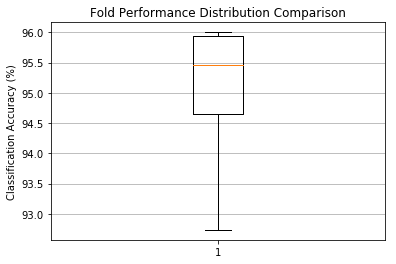

In [36]:
accuracies = []
for fold in range(number_of_folds):
    accuracies.append(k_fold_results[str(fold)]["accuracy"]*100)

plt.boxplot(accuracies, zorder=3)
plt.title("Fold Performance Distribution Comparison")
# plt.xlabel("Model")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_20:
     plt.savefig(RESULTS_PATH + "boxplot_20.pdf", format='pdf')

In [37]:
K.clear_session()

# Six-Fold Cross-Validation
Same method as employed when comparing the original model except this time user all users.

In [38]:
results_six_fold = {}
for user in users:
    results_six_fold[user] = {}

In [39]:
if RUN_EVALUATIONS:
    average_accuracy = 0
    average_loss = 0
    for user in users:
        data_split = split_train_validation_test(user)
        train_data = data_split["train_data"]
        train_labels = data_split["train_labels"]
        validation_data = data_split["validation_data"]
        validation_labels = data_split["validation_labels"]
        test_data = data_split["test_data"]
        test_labels = data_split["test_labels"]
        
        history, model = train_model(train_data, train_labels, validation_data, validation_labels, parameters, nb_epoch, patience)
        
        results = evaluate_model(model, test_data, test_labels, parameters[8], target_names)
        average_accuracy += results["accuracy"]
        average_loss += results["loss"]
        results_six_fold[user]["accuracy"] = results["accuracy"]
        results_six_fold[user]["loss"] = results["loss"]
    
    results_six_fold["avg_loss"] = average_loss/len(users)
    results_six_fold["avg_acc"] = average_accuracy/len(users)
    print("Average Loss:", average_loss/len(users))
    print("Average Accuracy:", average_accuracy/len(users))

## Save Results

In [40]:
if SAVE_RESULTS_6_FOLD:
    with open(RESULTS_PATH + "results_6_fold.pkl", 'wb') as results_file:
        pickle.dump(results_six_fold, results_file)

## Load Results

In [41]:
with open(RESULTS_PATH + "results_6_fold.pkl", 'rb') as results_file:
    results_six_fold = pickle.load(results_file)

## Visualize Results

In [42]:
print("Average Accuracy:", results_six_fold["avg_acc"]*100)
print("Average Loss:", results_six_fold["avg_loss"])

Average Accuracy: 79.38664939102966
Average Loss: 1.348568635080411


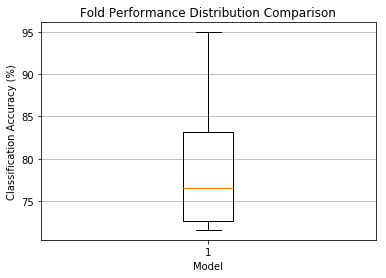

In [43]:
accuracies = []
for user in users:
    accuracies.append(results_six_fold[user]["accuracy"]*100)

plt.boxplot(accuracies, zorder=3)
plt.title("Fold Performance Distribution Comparison")
plt.xlabel("Model")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_6_FOLD:
     plt.savefig(RESULTS_PATH + "boxplot_6_fold.pdf", format='pdf')

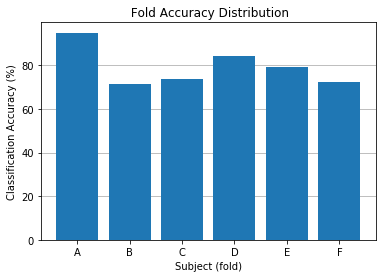

In [44]:
plt.bar(range(len(users)), accuracies, zorder=3)
plt.xticks(range(len(users)), users)
plt.xlabel("Subject (fold)")
plt.ylabel("Classification Accuracy (%)")
plt.title(" Fold Accuracy Distribution")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_6_FOLD:
    plt.savefig(RESULTS_PATH + "fold_accuracy_distribution_6_fold.pdf", format='pdf')
plt.show()

# Original Model Parameters

In [45]:
SAVE_RESULTS_TEST_C_BASE = False
SAVE_GRAPHS_TEST_C_BASE = False

SAVE_RESULTS_20_BASE = False
SAVE_GRAPHS_20_BASE = False

SAVE_RESULTS_6_FOLD_BASE = False
SAVE_GRAPHS_6_FOLD_BASE = False

In [46]:
nb_epochs = 20
batch_size = 64

In [47]:
def make_base_model():   
    """
    Create the CNN model with parameters found by A. Angelov
    :return: Sequential model
    """
    model = Sequential(name="Base")

    model.add(Convolution2D(64, (3, 3), padding='same',
                            input_shape=(1, img_rows, img_cols), activation='relu'))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    
    optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9,
                    nesterov=True)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

## Evaluate on Subject C

In [48]:
data_split = split_train_validation_test("C") # subject c is test subject

# 80% of each subject (excluding C)
train_data = data_split["train_data"]
train_labels = data_split["train_labels"]

# 20% taken from each subject (excluding C)
validation_data = data_split["validation_data"]
validation_labels = data_split["validation_labels"]

# subject C
test_data = data_split["test_data"]
test_labels = data_split["test_labels"]

In [49]:
if RUN_EVALUATIONS:
    model = make_base_model()
    
    history = model.fit(train_data, train_labels,
                        batch_size=batch_size,
                        epochs=nb_epochs,
                        shuffle=True, 
                        validation_data=(validation_data, validation_labels),
                        verbose=0)

In [50]:
if RUN_EVALUATIONS:
    results = evaluate_model(model, test_data, test_labels, batch_size, target_names)
    results["history"] = history.history

## Save Results

In [51]:
if SAVE_RESULTS_TEST_C_BASE:
    with open(RESULTS_PATH + "results_test_c_base.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

## Load Results

In [52]:
with open(RESULTS_PATH + "results_test_c_base.pkl", 'rb') as results_file:
    results = pickle.load(results_file)

## Visualize Results

In [53]:
print("Accuracy:", results["accuracy"]*100)

Accuracy: 78.30780818478533


### Accuracy

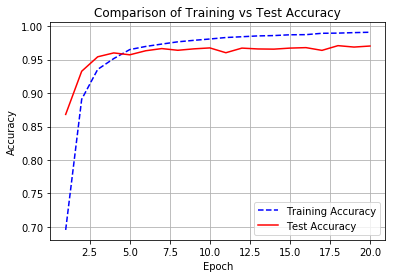

In [54]:
training_acc = results["history"]['acc']
test_acc = results["history"]['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_acc) + 1)

# Visualize loss history
plt.plot(epoch_count, training_acc, 'b--')
plt.plot(epoch_count, test_acc, 'r-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Comparison of Training vs Test Accuracy")
plt.grid()
if SAVE_GRAPHS_TEST_C:
    plt.savefig(RESULTS_PATH + "training_vs_test_acc_base.pdf", format='pdf')
plt.show()

### Loss

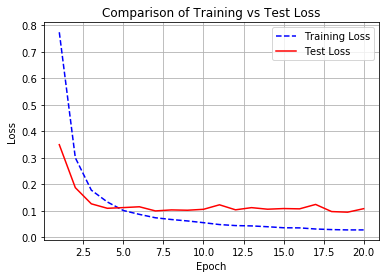

In [55]:
training_loss = results["history"]['loss']
test_loss = results["history"]['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'b--')
plt.plot(epoch_count, test_loss, 'r-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Comparison of Training vs Test Loss")
plt.grid()
if SAVE_GRAPHS_TEST_C:
    plt.savefig(RESULTS_PATH + "training_vs_test_loss_base.pdf", format='pdf')
plt.show()

### Confusion Matrix

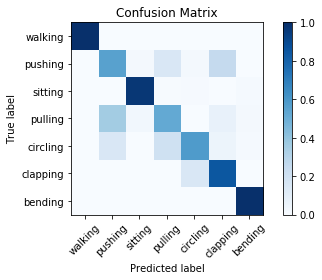

In [56]:
plot_confusion_matrix(results["confusion_matrix"], target_names,
                      save=SAVE_GRAPHS_TEST_C, path=RESULTS_PATH + "confusion_matrix_base.pdf")

In [57]:
K.clear_session()

# Evaluating on subset of the data (all subjects) 5-Fold
use 60% for training, 20% for validation (early stopping) and the final 20% for testing.

In [58]:
k_fold_results = {}
number_of_folds = 5
for fold in range(number_of_folds):
    k_fold_results[str(fold)] = {}

In [59]:
if RUN_EVALUATIONS:
    average_accuracy = 0
    average_loss = 0
    for fold in range(number_of_folds):
        test_fold = fold
        validation_fold = (test_fold + 1) % number_of_folds
        print("Fold:", fold)
        
        data_split = split_data(test_fold, validation_fold, number_of_folds)
        
        train_data = data_split["train_data"]
        train_labels = data_split["train_labels"]
        validation_data = data_split["validation_data"]
        validation_labels = data_split["validation_labels"]
        test_data = data_split["test_data"]
        test_labels = data_split["test_labels"]
        
        model = make_base_model()
    
        history = model.fit(train_data, train_labels,
                            batch_size=batch_size,
                            epochs=nb_epochs,
                            shuffle=True, 
                            validation_data=(validation_data, validation_labels),
                            verbose=0)
        
        results = evaluate_model(model, test_data, test_labels, batch_size, target_names)
        average_accuracy += results["accuracy"]
        average_loss += results["loss"]
        k_fold_results[str(fold)]["accuracy"] = results["accuracy"]
        k_fold_results[str(fold)]["loss"] = results["loss"]
        
    k_fold_results["average_accuracy"] = average_accuracy/number_of_folds
    k_fold_results["average_loss"] = average_loss/number_of_folds

## Save Results

In [60]:
if SAVE_RESULTS_20_BASE:
    with open(RESULTS_PATH + "results_test_20_base.pkl", 'wb') as results_file:
        pickle.dump(k_fold_results, results_file)

## Load Results

In [61]:
with open(RESULTS_PATH + "results_test_20_base.pkl", 'rb') as results_file:
    k_fold_results = pickle.load(results_file)

## Visualize Results

### Accuracy Fold Distribution

In [62]:
print("Average Accuracy:", k_fold_results["average_accuracy"]*100)
print("Average Loss:", k_fold_results["average_loss"])

Average Accuracy: 97.10634334520206
Average Loss: 0.11314814092131883


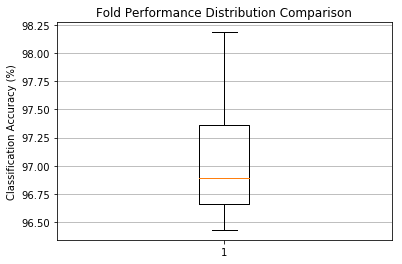

In [63]:
accuracies = []
for fold in range(number_of_folds):
    accuracies.append(k_fold_results[str(fold)]["accuracy"]*100)

plt.boxplot(accuracies, zorder=3)
plt.title("Fold Performance Distribution Comparison")
# plt.xlabel("Model")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_20_BASE:
     plt.savefig(RESULTS_PATH + "boxplot_20_base.pdf", format='pdf')

In [64]:
K.clear_session()

# Six-Fold Cross-Validation
Same method as employed when comparing the original model except this time user all users.

In [65]:
results_six_fold = {}
for user in users:
    results_six_fold[user] = {}

In [66]:
if RUN_EVALUATIONS:
    average_accuracy = 0
    average_loss = 0
    for user in users:
        data_split = split_train_validation_test(user)
        train_data = data_split["train_data"]
        train_labels = data_split["train_labels"]
        validation_data = data_split["validation_data"]
        validation_labels = data_split["validation_labels"]
        test_data = data_split["test_data"]
        test_labels = data_split["test_labels"]
        
        model = make_base_model()
    
        history = model.fit(train_data, train_labels,
                            batch_size=batch_size,
                            epochs=nb_epochs,
                            shuffle=True, 
                            validation_data=(validation_data, validation_labels),
                            verbose=0)
        
        results = evaluate_model(model, test_data, test_labels, batch_size, target_names)
        average_accuracy += results["accuracy"]
        average_loss += results["loss"]
        results_six_fold[user]["accuracy"] = results["accuracy"]
        results_six_fold[user]["loss"] = results["loss"]
    
    results_six_fold["avg_loss"] = average_loss/len(users)
    results_six_fold["avg_acc"] = average_accuracy/len(users)
    print("Average Loss:", average_loss/len(users))
    print("Average Accuracy:", average_accuracy/len(users))

## Save Results

In [67]:
if SAVE_RESULTS_6_FOLD_BASE:
    with open(RESULTS_PATH + "results_6_fold_base.pkl", 'wb') as results_file:
        pickle.dump(results_six_fold, results_file)

## Load Results

In [68]:
with open(RESULTS_PATH + "results_6_fold_base.pkl", 'rb') as results_file:
    results_six_fold = pickle.load(results_file)

## Visualize Results

In [69]:
print("Average Accuracy:", results_six_fold["avg_acc"]*100)
print("Average Loss:", results_six_fold["avg_loss"])

Average Accuracy: 78.48044614928872
Average Loss: 1.9231071929770376


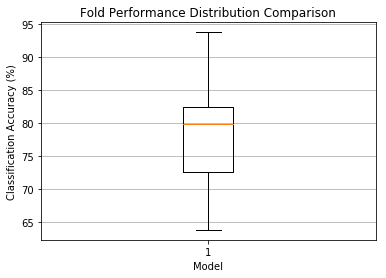

In [70]:
accuracies = []
for user in users:
    accuracies.append(results_six_fold[user]["accuracy"]*100)

plt.boxplot(accuracies, zorder=3)
plt.title("Fold Performance Distribution Comparison")
plt.xlabel("Model")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_6_FOLD:
     plt.savefig(RESULTS_PATH + "boxplot_6_fold_base.pdf", format='pdf')

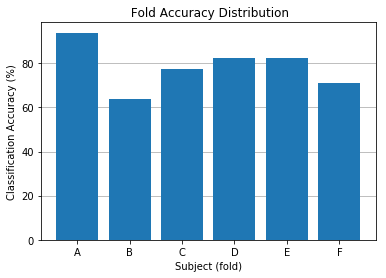

In [71]:
plt.bar(range(len(users)), accuracies, zorder=3)
plt.xticks(range(len(users)), users)
plt.xlabel("Subject (fold)")
plt.ylabel("Classification Accuracy (%)")
plt.title(" Fold Accuracy Distribution")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_6_FOLD_BASE:
    plt.savefig(RESULTS_PATH + "fold_accuracy_distribution_6_fold_base.pdf", format='pdf')
plt.show()